<font color='tomato'><font color="#CC3D3D"><p>
# Baseline Code (v1.0)

- **문제**   
*"각 패널에게 어떤 온라인 설문조사를 요청해야 응답할까?"*    
**KML Challenge 2023F**에서는 이 문제를 가장 잘 해결할 수 있는 예측 모델을 개발하는 것이 목적
- **평가척도**   
정확도(Accuracy)
- **데이터**   
   - train.csv(학습데이터), test.csv(평가테이터)
   - 각 데이터 포인트는 패널 정보, 설문정보, 응답여부(STATUS)로 구성

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import random
import pickle
import gc
import re
import warnings; warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

#sklearn module & utils
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore') 

#Scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Encoding
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#Modeling
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import shap
# from featurizer import KMeansFeaturizer 
from sklearn.cluster import KMeans

#Scoring
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

### Data Loading

In [2]:
train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')

In [3]:
train

,userID,surveyID,BIRTH,GENDER,REGION,TYPE,SQ1,SQ2,SQ3,SQ4,...,DQ4,DQ5,DQ6,DQ7,TITLE,IR,LOI,CATEGORIES,CPI,STATUS
0,p00000,s04673,1976.0,1.0,2.0,D,1.0,1976.0,1.0,"1,",...,NaN,NaN,NaN,NaN,해외-일반인의견조사(G-925574),100,13,NaN,715.0,1
1,p00000,s04675,1976.0,1.0,2.0,D,1.0,1976.0,1.0,"1,",...,NaN,NaN,NaN,NaN,해외-일반인의견조사(G-926698),100,10,NaN,550.0,1
2,p00000,s04683,1976.0,1.0,2.0,D,1.0,1976.0,1.0,"1,",...,NaN,NaN,NaN,NaN,해외---일반인-의견-조사-(DR-1379333)S,100,12,NaN,480.0,1
3,p00000,s04684,1976.0,1.0,2.0,D,1.0,1976.0,1.0,"1,",...,NaN,NaN,NaN,NaN,해외---일반인-의견-조사-(DR-8609533)S,100,12,NaN,480.0,1
4,p00000,s04686,1976.0,1.0,2.0,D,1.0,1976.0,1.0,"1,",...,NaN,NaN,NaN,NaN,해외---일반인-의견-조사-(DR-9958375)L,100,15,NaN,600.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813645,p16050,s05667,1983.0,1.0,16.0,D,1.0,1983.0,6.0,"4,",...,NaN,NaN,NaN,NaN,소비자의견조사(JY-PAS),30,9,"Smoking, Tobacco,Shopping, Retail",550.0,1
813646,p16050,s05802,1983.0,1.0,16.0,D,1.0,1983.0,6.0,"4,",...,NaN,NaN,NaN,NaN,소비자의견조사(JM-WR),5,15,"Shopping, Retail,Beverages - non alcoholic,Bev...",825.0,1
813647,p16050,s05838,1983.0,1.0,16.0,D,1.0,1983.0,6.0,"4,",...,NaN,NaN,NaN,NaN,소비자의견조사(JM-KB),50,15,"Finance, Banking",825.0,1
813648,p16050,s05899,1983.0,1.0,16.0,D,1.0,1983.0,6.0,"4,",...,NaN,NaN,NaN,NaN,일반인의견조사(GH-5),80,5,etc,275.0,1


In [4]:
train["STATUS"].value_counts()

STATUS
0    497085
1    316565
Name: count, dtype: int64

### 데이터 설명
- **패널(Panel) 데이터**
  - userID: 패널 ID
  - BIRTH: 생일(연도)
  - GENDER: 1(남자) 2(여자)
  - REGION: 거주지역
  - TYPE: 패널 구분
  - SQ1 ~ DQ7: 패널 가입 시 설문한 데이터로 각 필드에 대해서는 [상세설명](https://docs.google.com/spreadsheets/d/1pY6MYTSkyHrGLmMTU8tX_xlD8fPut6Ob/edit?usp=sharing&ouid=107121563618260277687&rtpof=true&sd=true) 참조
- **설문(Survey) 데이터**
  - surveyID: 설문 ID
  - TITLE: 설문 제목
  - IR: 난이도(응답가능성, 100이 최고)
  - LOI: 설문하는데 걸리는 시간 (분단위)
  - CATEGORIES: 설문 분류
  - CPI: 패널 응답 리워드 포인트(1P~)
- **응답(Response) 데이터**
  - STATUS: 응답여부 (Target)
  - (test 데이터의) ID: submission을 식별하기 위한 ID로 사용

### Data Preprocessing

In [5]:
# 결측값 비율이 30% 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] <= 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

userID 	 15155 	 0.0
surveyID 	 1293 	 0.0
BIRTH 	 76 	 0.0
GENDER 	 2 	 0.0
REGION 	 17 	 0.0
TYPE 	 3 	 0.0
SQ1 	 2 	 0.0009770785964481042
SQ2 	 82 	 0.0014293615190806859
SQ3 	 47 	 0.09023044306520002
SQ4 	 52 	 0.09058931973207153
SQ5 	 273 	 0.14450930989983407
SQ6 	 30 	 0.14490751551649972
SQ7 	 1234 	 0.1802556381736619
SQ8 	 1774 	 0.1831610643397038
A1 	 2768 	 0.2083279051189086
B1 	 131 	 0.21447796964296686
B2 	 120 	 0.2426792847047256
B3 	 110 	 0.24790757696798377
B4 	 715 	 0.2602888219750507
B5 	 669 	 0.26743317151109197
TITLE 	 1286 	 0.0
IR 	 42 	 0.0
LOI 	 26 	 0.0
CPI 	 43 	 0.0
STATUS 	 2 	 0.0


In [6]:
# 불필요한 ID들은 제외. SQ1 ~ SQ3는 GENDER, BIRTH, REGION과 중복이어서 제외!
features.remove('userID')
features.remove('surveyID')
features.remove('STATUS')
features.remove('SQ1')
features.remove('SQ2')
features.remove('SQ3')

In [7]:
# 거주 주택 형태: 1/2/3/4/5/6/97이 정상값
train.SQ4.value_counts()

SQ4
1,                           226496
1                            156663
3                             97597
1                             44106
2                             42385
3,                            34304
4                             32486
4,                            27938
2,                            25578
5                             11522
5,                            10608
2                              7375
4                              4984
3                              4592
5                              3281
6,                             3005
6                              1880
6                               853
7                               434
97,원룸                           413
97,단독주택                         395
97,맑음                           353
97,기숙사                          224
97                              218
97                              184
97,폭염                           179
97,흐림                           165
7                       

In [8]:
train['SQ4'] = train['SQ4'].astype(str)
train['SQ4'] = train['SQ4'].str.strip()

test['SQ4'] = test['SQ4'].astype(str)
test['SQ4'] = test['SQ4'].str.strip()

In [9]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    elif x in ['97,원룸', '97,단독주택', '97,맑음', '97,기숙사', '97,폭염', '97,흐림', '97,덥다', '97,기와집', '97,관사', '97,모름', '97,사택(아파트)', '97,타운하우스', '97,다가구', '97,교회사택', '97,쪽방촌', '97,모텔', '97,잘 모름', '97,맑다', '97,프라이드1', '97,무더움', '97,비', '97,상가 내', '97,투룸', '97,추워요', '97,점포임대주택', '97,사택(공동주거)']:
        return 97
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

In [10]:
train.SQ4.value_counts()

SQ4
1,                           226496
1                            200769
3                            102189
nan                           73708
2                             49760
4                             37470
3,                            34304
4,                            27938
2,                            25578
5                             14803
5,                            10608
6,                             3005
6                              2733
7                               595
97,원룸                           413
97                              402
97,단독주택                         395
97,맑음                           353
97,기숙사                          224
97,폭염                           179
97,흐림                           165
97,덥다                           146
97,기와집                          112
97,관사                            97
97,모름                            89
97,사택(아파트)                       89
97,타운하우스                         85
97,다가구                  

In [11]:
# 최종학력: 1/2/3/4 정상값
train.SQ5.value_counts()[:20]

SQ5
3.0                 261915
1.0                 117143
3                    82671
4.0                  45968
1                    44135
2.0                  43504
2                    28922
3.0                  20543
4                    11984
99.0                  7539
1.0                   4391
4.0                   3075
2.0                   1567
8.0                   1037
16.0                   760
1,2,3,5                493
12,2,9                 491
1,13,2,3,4,5,8,9       350
1,13,18,2,4,5,9        331
10.0                   316
Name: count, dtype: int64

In [12]:
train['SQ5'] = train['SQ5'].astype(str)
train['SQ5'] = train['SQ5'].str.strip()

test['SQ5'] = test['SQ5'].astype(str)
test['SQ5'] = test['SQ5'].str.strip()

In [13]:
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [14]:
train.SQ5.value_counts()

SQ5
3     365129
1     165669
99    128724
2      73993
4      61027
98     19108
Name: count, dtype: int64

In [15]:
# 결혼여부: 1/2/97 정상값
train.SQ6.value_counts()

SQ6
2                                         186233
1                                         151556
2,                                        112287
1,                                         68424
4                                          58570
3                                          44955
2                                          25121
5                                          17839
1                                          17779
97                                          4010
3                                           2513
4                                           2069
97,이혼                                       1106
97                                           991
99                                           756
2,21,5,8,9                                   394
5                                            387
97,사별                                        270
99                                           237
97,별거                                         72
10              

In [16]:
train['SQ6'] = train['SQ6'].astype(str)
train['SQ6'] = train['SQ6'].str.strip()

test['SQ6'] = test['SQ6'].astype(str)
test['SQ6'] = test['SQ6'].str.strip()

In [17]:
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    elif x in ['97', '97,이혼', '97,사별', '97,별거']:
        return 97
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [18]:
train.SQ6.value_counts()

SQ6
2     323641
99    245402
1     237759
97      6449
98       399
Name: count, dtype: int64

In [19]:
# 자녀 정보: 1~16/99 정상값
train.SQ7.value_counts()

SQ7
99.0                 77505
99                   70575
4.0                  34714
16.0                 30856
3.0                  29374
                     ...  
1,13                     5
13,18,2,3,4,5,7          5
1,10,11,2,3,4,5,7        3
1,13,2,5,7,8             3
1,16,2,3,4,5,8,9         2
Name: count, Length: 1234, dtype: int64

In [20]:
train['SQ7'] = train['SQ7'].astype(str)
train['SQ7'] = train['SQ7'].str.strip()

test['SQ7'] = test['SQ7'].astype(str)
test['SQ7'] = test['SQ7'].str.strip()

In [21]:
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [22]:
train.SQ7.value_counts()

SQ7
99    320417
98    142955
1      95151
3      50462
4      46418
8      45821
2      24499
5      20689
16     17815
7      10456
6       9829
12      5514
14      5477
9       4933
13      4305
15      3925
11      2906
10      2078
Name: count, dtype: int64

In [23]:
# 가족수: 1/2/3/4/5 정상값
train.SQ8.value_counts()[:10]

SQ8
3.0    117492
4.0    116477
1.0     84890
2.0     52642
3       45629
1       45602
4       40181
5.0     26662
2       15744
99      12504
Name: count, dtype: int64

In [24]:
train['SQ8'] = train['SQ8'].astype(str)
train['SQ8'] = train['SQ8'].str.strip()

test['SQ8'] = test['SQ8'].astype(str)
test['SQ8'] = test['SQ8'].str.strip()

In [25]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0','5.0']:
        return int(x[0])
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [26]:
train.SQ8.value_counts()

SQ8
99    257202
3     163121
4     156658
1     130492
2      68386
5      37791
Name: count, dtype: int64

In [27]:
# 최근 구입/렌트 가전제품: 1~22/99 정상값
train.A1.value_counts()

A1
1                                        138548
3                                         77358
99                                        61137
2                                         20397
4                                         19702
                                          ...  
12,14,16,17,19,21,6,7,8                       1
1,10,13,14,15,16,17,2,21,4,5,7,8              1
1,10,12,13,14,16,17,19,2,21,4,5,6,7,8         1
1,13,15,19,2,21,3,4,5,8,9                     1
1,13,16,2,21,3,4,5,7,9                        1
Name: count, Length: 2768, dtype: int64

In [28]:
train['A1'] = train['A1'].astype(str)
train['A1'] = train['A1'].str.strip()

test['A1'] = test['A1'].astype(str)
test['A1'] = test['A1'].str.strip()

#### A1_count

In [31]:
def count_numbers(pattern):
    # 문자열에서 ','를 기준으로 분리
    pattern = str(pattern)
    numbers = pattern.split(',')

    # 숫자 개수를 저장할 딕셔너리 초기화
    count_num = 0

    # 각 숫자의 출현 횟수 세기
    for number in numbers:
        number = number.strip()
        if number == 'nan':
            return 0
        else:
            count_num += 1

    return count_num

# train 데이터에 대해 새로운 피처 생성
train['A1_count'] = train['A1'].apply(count_numbers)

# test 데이터에 대해 새로운 피처 생성
test['A1_count'] = test['A1'].apply(count_numbers)

In [32]:
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [33]:
train.A1.value_counts()

A1
99    275448
98    228070
1     138548
3      77358
2      20397
4      19702
5      10023
13      7192
20      5478
10      5460
21      4553
7       3816
6       2712
9       2399
17      2078
11      1742
12      1564
16      1519
15      1394
18      1385
8       1305
22       799
19       486
14       222
Name: count, dtype: int64

In [34]:
# 휴대폰 통신망 종류: 1~8/99 정상값
train.B1.value_counts()

B1
4.0                   144144
8.0                    77972
99                     70360
1                      61165
4                      49218
                       ...  
1,10,2,5,6,9               1
10,2                       1
1,10,2,3,4,6,7,8,9         1
10,2,4,6                   1
1,4,6,7                    1
Name: count, Length: 131, dtype: int64

In [35]:
train['B1'] = train['B1'].astype(str)
train['B1'] = train['B1'].str.strip()

test['B1'] = test['B1'].astype(str)
test['B1'] = test['B1'].str.strip()

In [36]:
def handle_profile(x):    
    if x in ['1','1.0']:
        return 1
    elif x in ['2', '2.0']:
        return 2
    elif x in ['3', '3.0']:
        return 3
    elif x in ['4', '5', '6', '7', '4.0', '5.0', '6.0', '7.0']:
        return 4
    elif x in ['8', '8.0']:
        return 5
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [37]:
# 가입한 이동통신사: 1~6/97 정상값 
train.B2.value_counts()

B2
1.0            125631
1               90925
3.0             61414
99              50407
2               42995
                ...  
2,3,4,6,7,9         1
1,3,5,6             1
1,2,5,97            1
6,97                1
1,4,5,97            1
Name: count, Length: 120, dtype: int64

In [38]:
train['B2'] = train['B2'].astype(str)
train['B2'] = train['B2'].str.strip()

test['B2'] = test['B2'].astype(str)
test['B2'] = test['B2'].str.strip()

In [39]:
def handle_profile(x):    
    if x in ['1', '1.0']:
        return 1
    elif x in ['2', '2.0']:
        return 2
    elif x in ['3', '3.0']:
        return 3
    elif x in ['4', '4.0']:
        return 4
    elif x in ['5', '5.0']:
        return 5
    elif x in ['6', '6.0']:
        return 6
    elif re.search(r',.*?,', str(x)):
        return 96
    elif x in ['97', '97.0']:
        return 97
    else:
        return 99

train['B6'] = train['B2'].apply(handle_profile)
test['B6'] = test['B2'].apply(handle_profile)

In [40]:
train['B6'].value_counts()

B6
99    295375
1     216556
3     102627
2      67828
4      57746
5      48210
96     18818
6       4405
97      2085
Name: count, dtype: int64

In [41]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [42]:
train.B2.value_counts()

B2
99    581376
1      90925
2      42995
3      41213
5      30163
4      24604
6       2374
Name: count, dtype: int64

In [43]:
# 휴대폰 브랜드: 1~7/97/99
train.B3.value_counts()

B3
1              285468
2               96497
99              77757
3               68090
1,              25590
                ...  
2,4,5,6,97          1
1,2,4,7,8,9         1
1,3,5               1
5,97                1
1,2,3,4,7           1
Name: count, Length: 110, dtype: int64

In [44]:
train['B3'] = train['B3'].astype(str)
train['B3'] = train['B3'].str.strip()

test['B3'] = test['B3'].astype(str)
test['B3'] = test['B3'].str.strip()

In [45]:
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    elif re.search(r',.*?,', str(x)):
        return 98
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [46]:
train.B3.value_counts()

B3
1     311058
4     242947
2     100355
99     77967
3      77260
98      4063
Name: count, dtype: int64

#### B5_count

In [50]:
def count_numbers(pattern):
    # 문자열에서 ','를 기준으로 분리
    pattern = str(pattern)
    numbers = pattern.split(',')

    # 숫자 개수를 저장할 딕셔너리 초기화
    count_num = 0

    # 각 숫자의 출현 횟수 세기
    for number in numbers:
        number = number.strip()
        if number == 'nan':
            return 0
        else:
            count_num+=1

    return count_num

train['B5_count'] = train.B5.apply(count_numbers)
test['B5_count'] = test.B5.apply(count_numbers)

In [51]:
# 서베이 제목에서 유용한 정보 추출
train.TITLE.value_counts()

TITLE
일반인의견조사(Rm-K)            7506
소비자의견조사(HJ-JJ)           5087
소비자의견조사(JM-WR)           5037
소비자의견조사(SM-OT-Pag)       4912
일반인의견조사(M-TK)            4481
                         ... 
해외-일반인의견조사(G-1003288)       1
해외-일반인의견조사(G-1004081)       1
해외-일반인의견조사(G-997511)        1
해외-일반인의견조사(G-992275)        1
해외-일반인의견조사(G-960414)        1
Name: count, Length: 1286, dtype: int64

In [52]:
word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [53]:
# 응답률 feature 생성
res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()
train = train.merge(res_freq, how='left').merge(send_freq, how='left')
train['RESRATE'] = train['FREQ'] / train['SEND']
del train['FREQ'], train['SEND']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'RESRATE']], how='left')

features.extend(['RESRATE'])

### Feature Create

**패널 ID별 응답 리워드, 난이도, 시간 관련**

In [54]:
# 패널의 총 리워드 포인트, 평균/최소/최대 리워드 포인트

# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()

train = train.merge(Points_earned, how='left')
train = train.merge(Points_earned_mean, how='left')

train['Points_earned'].fillna(0, inplace = True)
train['Points_earned_mean'].fillna(0, inplace = True)

test = test.merge(Points_earned, how='left')
test = test.merge(Points_earned_mean, how='left')

test['Points_earned'].fillna(0, inplace = True) 
test['Points_earned_mean'].fillna(0, inplace = True)

In [55]:
# 패널이 응한 설문의 평균난이도
IR = train.query('STATUS==1').groupby('userID')['IR'].agg([('AVG_IR', np.mean)]).reset_index()
                  
train = train.merge(IR, how='left')
test = test.merge(IR, how='left')

In [56]:
# 패널 ID 별 획득 평균 시간
LOI = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('AVG_LOI', np.mean)]).reset_index())
train = train.merge(LOI, how='left')
test = test.merge(LOI, how='left')

**BIRTH, REGION 별 응답확률**

In [57]:
BIRTH_status_mean = pd.DataFrame(train.groupby('BIRTH')['STATUS'].agg([('BIRTH_status_mean',np.mean)])).reset_index()

REGION_status_mean = pd.DataFrame(train.groupby('REGION')['STATUS'].agg([('REGION_status_mean',np.mean)])).reset_index()

train = train.merge(BIRTH_status_mean, how='left').merge(REGION_status_mean, how='left')
test = test.merge(BIRTH_status_mean, how='left').merge(REGION_status_mean, how='left')

**IR 별 응답확률**

In [58]:
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})
train = train.merge(train_IR,how='left')
test = test.merge(train_IR,how='left')
test.STATUS_ratio_IR=test.STATUS_ratio_IR.fillna(test.STATUS_ratio_IR.mean())

**LOI별 응답확률**

In [59]:
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})
train = train.merge(train_LOI,how='left')
test = test.merge(train_LOI,how='left')
test.STATUS_ratio_LOI=test.STATUS_ratio_LOI.fillna(test.STATUS_ratio_LOI.mean())

**CPI 별 응답확률**

In [60]:
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})
train = train.merge(train_CPI,how='left')
test = test.merge(train_CPI,how='left')
test.STATUS_ratio_CPI=test.STATUS_ratio_CPI.fillna(test.STATUS_ratio_CPI.mean())

**응답률 * 서베이 횟수**

In [61]:
survey_count = train.groupby('userID')['userID'].count()#.reset_index()
survey_count.name = 'user'
survey_count.reset_index()

RES_RATE = train.STATUS.groupby(train.userID).sum() / train.STATUS.groupby(train.userID).count()
RES_RATE_survey_sum = RES_RATE*survey_count
RES_RATE_survey_sum.name = 'RES_RATE_survey_sum'

train = train.merge(RES_RATE_survey_sum,on='userID', how = 'left')
test = test.merge(RES_RATE_survey_sum,on='userID', how = 'left')

#### 설문조사별 응답률, 설문조사별 응답률 * 횟수

In [62]:
survey_count = train.groupby('surveyID')['surveyID'].count()#.reset_index()
survey_count.name = 'survey'
survey_count.reset_index()


survey_p = train.groupby('surveyID')['IR'].agg([('survey_p',np.mean)]).reset_index()

survey_p['survey_p_survey_sum']= survey_p['survey_p']*survey_count.reset_index()['survey']

train = train.merge(survey_p,on='surveyID', how = 'left')
test = test.merge(survey_p,on='surveyID', how = 'left')
test['survey_p'] = test['survey_p'].fillna(0)

**TYPE 별 응답확률**

In [63]:
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

**유저아이디별 응답횟수**

In [64]:
res_cnt = train[train.STATUS== 1].groupby("userID").surveyID.count()
train["res_cnt"] = train["userID"].map(dict(res_cnt))
test["res_cnt"] = test["userID"].map(dict(res_cnt))

test["res_cnt"] = test["res_cnt"].fillna(0)

**성별응답확률**

In [65]:
res_freq = train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('g_i','mean')]).reset_index()
train = pd.merge(train, res_freq, how='left')
test = pd.merge(test, res_freq, how='left')
test.FREQ = test.g_i.fillna(test.g_i.mean())

**성별 응답난이도 평균**

In [66]:
GENDER_IR = train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('GENDER_IR',np.mean)]).reset_index()

train = pd.merge(train, GENDER_IR, how='left')
test = pd.merge(test, GENDER_IR, how='left')

**TYPE 별 CPI 평균**

In [67]:
TYPE_CPI_mean = pd.DataFrame(train.groupby('TYPE')['CPI'].agg([('TYPE_CPI_mean',np.mean)])).reset_index()

train = train.merge(TYPE_CPI_mean, how='left')
test = test.merge(TYPE_CPI_mean, how='left')

**생년->나이**

In [68]:
train["AGE"] = 2022- train["BIRTH"]
test["AGE"] = 2022- test["BIRTH"]

#### 응답률 + 응답률 * 서베이 횟수

In [69]:
train['RESRATE_sum_RES_RATE_survey_sum']= train['RESRATE']+train['RES_RATE_survey_sum']
test['RESRATE_sum_RES_RATE_survey_sum']= test['RESRATE']+test['RES_RATE_survey_sum']

#### 성별 * 응답률

In [70]:
train['GENDER_multiply_RESRATE'] = train['GENDER'] * train['RESRATE']
test['GENDER_multiply_RESRATE'] = test['GENDER'] * test['RESRATE']

#### 응답률 - 획득 포인트 평균

In [71]:
train['RESRATE_diff_Points_earned_mean'] = train['RESRATE'] - train['Points_earned_mean']
test['RESRATE_diff_Points_earned_mean'] = test['RESRATE'] - test['Points_earned_mean']

#### 유저아이디별 응답횟수 + 응답률(인데 -로 만들었습니다...)

In [72]:
train['res_cnt_sum_RESRATE'] = train['res_cnt'] - train['RESRATE']
test['res_cnt_sum_RESRATE'] = test['res_cnt'] - test['RESRATE']

#### 지역  * 응답률

In [73]:
train['REGION_multiply_RESRATE'] = train['REGION'] * train['RESRATE']
test['REGION_multiply_RESRATE'] = test['REGION'] * test['RESRATE']

#### 획득 포인트 평균  +  응답률

In [74]:
train['Points_earned_mean_sum_RESRATE'] = train['Points_earned_mean'] + train['RESRATE']
test['Points_earned_mean_sum_RESRATE'] = test['Points_earned_mean'] + test['RESRATE']

#### 유저아이디별 응답횟수 * 성별

In [75]:
train['res_cnt_multiply_GENDER'] = train['res_cnt'] * train['GENDER']
test['res_cnt_multiply_GENDER'] = test['res_cnt'] * test['GENDER']

#### (유저아이디별 응답횟수) + (응답률 * 서베이 횟수)

In [76]:
train['res_cnt_sum_RES_RATE_survey_sum'] = train['res_cnt'] + train['RES_RATE_survey_sum']
test['res_cnt_sum_RES_RATE_survey_sum'] = test['res_cnt'] + test['RES_RATE_survey_sum']

#### (응답률 * 서베이 횟수) / 유저아이디별 응답횟수 * 100

In [77]:
train['RES_RATE_survey_sum_ratio_res_cnt'] = train['RES_RATE_survey_sum'] / train['res_cnt'] * 100
test['RES_RATE_survey_sum_ratio_res_cnt'] = test['RES_RATE_survey_sum'] / test['res_cnt'] * 100

#### 유저아이디별 응답횟수 / (응답률 * 서베이 횟수) * 100

In [78]:
train['res_cnt_ratio_RES_RATE_survey_sum'] = train['res_cnt'] / train['RES_RATE_survey_sum'] * 100
test['res_cnt_ratio_RES_RATE_survey_sum'] = test['res_cnt'] / test['RES_RATE_survey_sum'] * 100

#### 설문지역, 설문대상자유형

In [79]:
train['설문지역'] = train['TITLE'].apply(lambda x: '해외' if '해외' in str(x) else '국내')
train['설문대상자유형'] = train['TITLE'].apply(lambda x: '일반인' if '일반인' in str(x) else ('소비자' if '소비자' in str(x) else '기타'))

test['설문지역'] = test['TITLE'].apply(lambda x: '해외' if '해외' in str(x) else '국내')
test['설문대상자유형'] = test['TITLE'].apply(lambda x: '일반인' if '일반인' in str(x) else ('소비자' if '소비자' in str(x) else '기타'))

#### 동일설문발송횟수

In [80]:
train['동일설문발송횟수'] = train.groupby(['userID', 'TITLE']).cumcount() + 1
test['동일설문발송횟수'] = test.groupby(['userID', 'TITLE']).cumcount() + 1

#### 연령대

In [81]:
train['연령대'] = train['AGE'] // 10
test['연령대'] = test['AGE'] // 10

#### 아줌마, 아저씨

In [82]:
def a_j_c(age, gender):
    return np.where((age == 3.0) & (gender == 1), '맞음', '아님')

train['a_j_c'] = a_j_c(train['연령대'], train['GENDER'])
test['a_j_c'] = a_j_c(test['연령대'], test['GENDER'])

In [83]:
def a_j_m(age, gender):
    return np.where((age == 4.0) & (gender == 2), '맞음', '아님')

train['a_j_m'] = a_j_m(train['연령대'], train['GENDER'])
test['a_j_m'] = a_j_m(test['연령대'], test['GENDER'])

#### 연령대별 응답확률

In [84]:
BIRTH_range_status_mean = pd.DataFrame(train.groupby('연령대')['STATUS'].agg([('연령대_status_mean',np.mean)])).reset_index()

train = train.merge(BIRTH_range_status_mean, how='left')
test = test.merge(BIRTH_range_status_mean, how='left')

**난이도 대비 응답시간**

In [86]:
train['ResponseTimePerDifficulty'] = train['LOI'] / train['IR']
test['ResponseTimePerDifficulty'] = test['LOI'] / test['IR']

In [87]:
# train 데이터 처리
train['ResponseTimePerDifficulty'].replace([np.inf, -np.inf], np.nan, inplace=True)
train['ResponseTimePerDifficulty'].fillna(train['ResponseTimePerDifficulty'].mean(), inplace=True)

# test 데이터 처리 (train 데이터와 동일한 처리)
test['ResponseTimePerDifficulty'].replace([np.inf, -np.inf], np.nan, inplace=True)
test['ResponseTimePerDifficulty'].fillna(train['ResponseTimePerDifficulty'].mean(), inplace=True)

**유저아이디별 응답횟수 * 성별 응답난이도 평균**

In [88]:
train['res_cnt_GENDER_IR'] = train['res_cnt'] * train['GENDER_IR']
test['res_cnt_GENDER_IR'] = test['res_cnt'] * test['GENDER_IR']

**TYPE 별 응답확률 * 응답률**

In [89]:
train['TYPE_mean_RESRATE'] = train['TYPE_mean'] * train['RESRATE']
test['TYPE_mean_RESRATE'] = test['TYPE_mean'] * test['RESRATE']

**난이도*시간**

In [90]:
train['DifficultyTimesDuration'] = train['IR'] * train['LOI']
test['DifficultyTimesDuration'] = test['IR'] * train['LOI']

**점수/시간  점수*시간**

In [91]:
#점수/시간
train['CPI_Per_LOI'] = train['CPI'] / train['LOI']
test['CPI_Per_LOI'] = test['CPI'] / test['LOI']

#점수*시간
train['CPI_Times_LOI'] = train['CPI'] * train['LOI']
test['CPI_Times_LOI'] = test['CPI'] * test['LOI']

#### A1 추가 분류

In [92]:
import pandas as pd
import numpy as np
import re

# Train 데이터에 대한 A1_new 피처 생성
def create_A1_new(train):
    values = {
        1: 1,
        2: 2,
        3: 2,
        4: 3,
        5: 4,
        6: 4,
        7: 4,
        8: 5,
        9: 6,
        10: 6,
        11: 6,
        12: 7,
        20: 7,
        13: 8,
        14: 9,
        19: 9,
        15: 10,
        16: 11,
        17: 11,
        18: 12,
        19: 9,
        21: 13,
        22: 14,
        99: 99
    }
    train['A1_new'] = train['A1'].map(values).fillna(99)
    return train

# Train 데이터에 대한 A1_new 피처 생성
train = create_A1_new(train)

# Test 데이터에 대한 A1_new 피처 생성
test = create_A1_new(test)

In [93]:
A1_new_res_mean = pd.DataFrame(train.groupby('A1_new')['RESRATE'].agg([('A1_new_res_mean',np.mean)])).reset_index()
train = train.merge(A1_new_res_mean, how='left')
test = test.merge(A1_new_res_mean, how='left')

In [94]:
#CPI별응답확률*LOI
train['STATUS_ratio_CPI_MUL_LOI']=train['STATUS_ratio_CPI']*train['LOI']
test ['STATUS_ratio_CPI_MUL_LOI']=test['STATUS_ratio_CPI']*test['LOI']

In [95]:
#TYPE별CPI평균*LOI
train['TYPE_CPI_mean_MUL_LOI']=train['TYPE_CPI_mean']*train['LOI']
test ['TYPE_CPI_mean_MUL_LOI']=test['TYPE_CPI_mean']*test['LOI']

In [96]:
#성별응답난이도평균*시간
train['GENDER_IR_MUL_LOI']=train['GENDER_IR']*train['LOI']
test['GENDER_IR_MUL_LOI'] = test['GENDER_IR']*test['LOI']

#### 데이터 재정의

In [97]:
features = ['BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'AVG_LOI', 'AVG_IR',
            'TITLE','IR', 'LOI', 'CPI', 'RESRATE', 'Points_earned', 'Points_earned_mean', 'BIRTH_status_mean', 'REGION_status_mean',
             'STATUS_ratio_IR', 'STATUS_ratio_CPI', 'STATUS_ratio_LOI', 'TYPE_mean', 'res_cnt', 'g_i', 'AGE', 'RES_RATE_survey_sum',
            'RESRATE_sum_RES_RATE_survey_sum', 'GENDER_multiply_RESRATE', 'RESRATE_diff_Points_earned_mean',
            'res_cnt_sum_RESRATE', 'REGION_multiply_RESRATE', 'Points_earned_mean_sum_RESRATE','res_cnt_multiply_GENDER',
            'res_cnt_sum_RES_RATE_survey_sum', 'RES_RATE_survey_sum_ratio_res_cnt', 'res_cnt_ratio_RES_RATE_survey_sum',
           'B5_count', 'survey_p', 'ResponseTimePerDifficulty', 'B6', 'A1_new', 'A1_count', 'userID', 'surveyID', 'survey_p_survey_sum']
#막줄이 마지막 테스트 때 새로 추가

In [98]:
# 데이터 필터링
X_train = train[features]
X_test = test[features]
y_train = train['STATUS']

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = test.ID

# 메모리 낭비를 막기위해 불필요한 데이터 삭제
del train, test 
gc.collect()

0

In [99]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813650 entries, 0 to 813649
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   BIRTH                      813650 non-null  float64
 1   GENDER                     813650 non-null  float64
 2   REGION                     813650 non-null  float64
 3   TYPE                       813650 non-null  object 
 4   SQ4                        813650 non-null  object 
 5   SQ5                        813650 non-null  int64  
 6   SQ6                        813650 non-null  int64  
 7   SQ7                        813650 non-null  int64  
 8   SQ8                        813650 non-null  int64  
 9   A1                         813650 non-null  int64  
 10  B1                         813650 non-null  int64  
 11  B2                         813650 non-null  int64  
 12  B3                         813650 non-null  int64  
 13  B4                         60

In [100]:
# 범주형 변수와 수치형 변수를 분리
cat_features = ['GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'userID', 'surveyID']
num_features = list(set(X_train.columns) - set(cat_features))

### Feature Engineering

##### Impute missing values

In [101]:
# 응답률 geature 결측값을 평균으로 대체
mean_resrate = X_train['RESRATE'].mean()
X_train['RESRATE'] = X_train['RESRATE'].fillna(mean_resrate)
X_test['RESRATE'] = X_test['RESRATE'].fillna(mean_resrate)

#'AVG_IR' 열의 결측치를 중앙값으로 대체
median_AVG_IR = X_train['AVG_IR'].median()
X_train['AVG_IR'].fillna(median_AVG_IR, inplace=True)
X_test['AVG_IR'].fillna(median_AVG_IR, inplace=True)

# 유저아이디별 응답횟수 결측치 처리
X_train["res_cnt"] = X_train["res_cnt"].fillna(0)

In [102]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리
if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])

if len(cat_features) > 0:  
    imp_cat = SimpleImputer(strategy="constant", fill_value="없음")
    X_train[cat_features] = imp_cat.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp_cat.transform(X_test[cat_features])
# if len(cat_features) > 0:  
#     imp = SimpleImputer(strategy="most_frequent")
#     X_train[cat_features] = imp.fit_transform(X_train[cat_features])
#     X_test[cat_features] = imp.transform(X_test[cat_features])

In [103]:
X_train[cat_features] = X_train[cat_features].astype(str)
X_test[cat_features] = X_test[cat_features].astype(str)

In [104]:
X_train['GENDER'] = X_train['GENDER'].astype(float).astype(int)
X_train['REGION'] = X_train['REGION'].astype(float).astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(float).astype(int)
X_test['REGION'] = X_test['REGION'].astype(float).astype(int)

##### Transform features (Feature Scaling)

In [105]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [106]:
scaler = PowerTransformer(standardize=False)#standardize=True 스케일링까지
X_train[num_features] = scaler.fit(X_train[num_features]).transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

##### Encode categorical features

In [107]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude='object')
    X_t = X_t.select_dtypes(exclude='object') 
    for class_ in class_names:
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj,y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)
        X_t = pd.concat([X_t,temp_t],axis=1)
      
    return X, X_t

X_train, X_test = catboost_encoder_multiclass(X_train,X_test,y_train)

<font color="#CC3D3D"><p>
##### Feature selection using SHAP

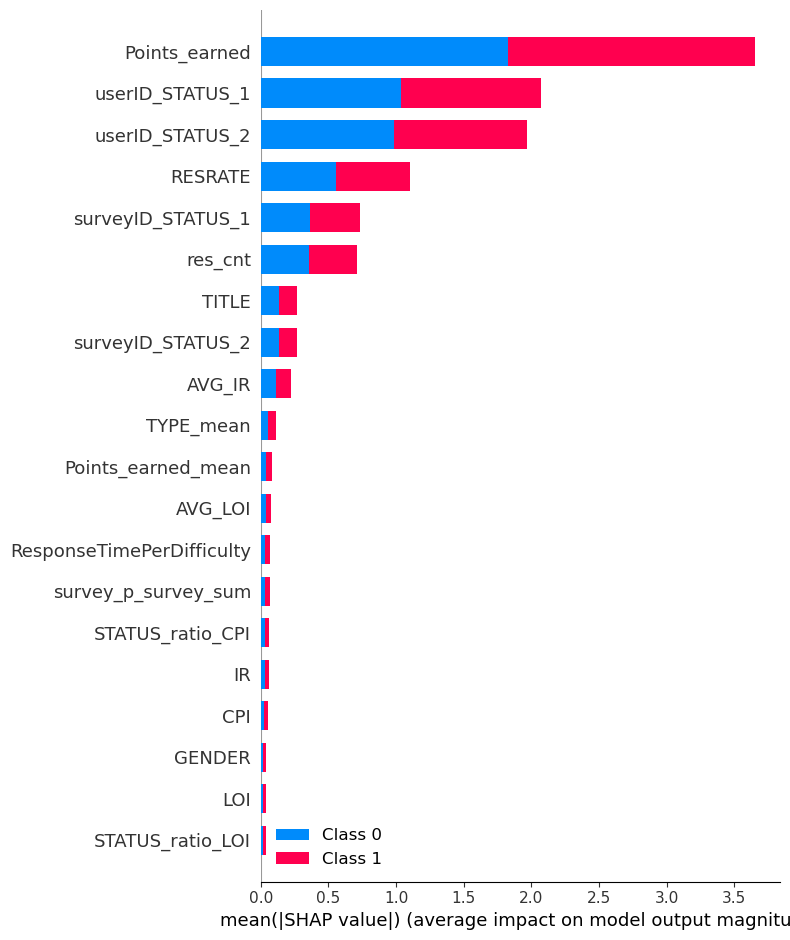

,column_name,shap_importance
10,Points_earned,1.827226
41,userID_STATUS_1,1.036486
55,userID_STATUS_2,0.982888
9,RESRATE,0.553379
42,surveyID_STATUS_1,0.365227
18,res_cnt,0.355157
5,TITLE,0.134692
56,surveyID_STATUS_2,0.133043
4,AVG_IR,0.111896
17,TYPE_mean,0.055457


In [108]:
#
# Method: Using SHAP values 
#

# DF, based on which importance is checked
X_importance = X_test

# # Explain model predictions using shap library:
model = LGBMClassifier(random_state=42, objective='binary', metric='binary_error').fit(X_train, y_train, eval_metric = 'accuracy',)#속도 빠르게 하려고 LGBM 씀
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [109]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
features_selected = importance_df.query('shap_importance > 0.0009').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]

print(X_train.shape)

(813650, 28)


In [110]:
X_train.columns

Index(['Points_earned', 'userID_STATUS_1', 'userID_STATUS_2', 'RESRATE',
       'surveyID_STATUS_1', 'res_cnt', 'TITLE', 'surveyID_STATUS_2', 'AVG_IR',
       'TYPE_mean', 'Points_earned_mean', 'AVG_LOI',
       'ResponseTimePerDifficulty', 'survey_p_survey_sum', 'STATUS_ratio_CPI',
       'IR', 'CPI', 'GENDER', 'LOI', 'STATUS_ratio_LOI', 'BIRTH',
       'REGION_status_mean', 'STATUS_ratio_IR', 'REGION', 'AGE', 'B5_count',
       'BIRTH_status_mean', 'SQ6_STATUS_2'],
      dtype='object')

#### 군집화

In [111]:
# 여러 K 값에 대해 KMeans 모델을 학습하고 이너셔를 계산하는 함수
def find_optimal_k(X, max_k):
    inertias = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    return inertias

# 최적의 K 값을 찾아 엘보우 그래프를 그리는 함수
def plot_elbow(X, max_k):
    inertias = find_optimal_k(X, max_k)

    # 엘보우 그래프 그리기
    plt.plot(range(1, max_k + 1), inertias, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.show()

# 예시 데이터
example_data = np.random.rand(100, 2)

# 최적의 K 값을 찾아 엘보우 그래프 그리기
max_k_value = 10
plot_elbow(example_data, max_k_value)

In [112]:
#
# KMeansFeaturizer: k-means 군집분석을 실행하여 각 데이터 포인트에 가장 가까운 군집 ID를 새로운 feature로 반환  
#   

# Specify the number of clusters (k)
# num_clusters = 10

optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(X_train)

train_cluster_features = kmeans.transform(X_train)
train_cluster_features = pd.DataFrame(train_cluster_features, columns=[f'CLUSTER_{i}' for i in range(optimal_k)])

test_cluster_features = kmeans.transform(X_test)
test_cluster_features = pd.DataFrame(test_cluster_features, columns=[f'CLUSTER_{i}' for i in range(optimal_k)])

X_train = pd.concat([X_train, train_cluster_features], axis=1)
X_test = pd.concat([X_test, test_cluster_features], axis=1)

### Model building

In [113]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [114]:
from sklearn.metrics import accuracy_score

#### 옵튜나

In [115]:
# def objective(trial):
#     params = {
#         "n_estimators": 10000,
#         "random_state" : 42,
#         "n_jobs" : -1,
#         "learning_rate": 0.05,
#         "num_leaves": trial.suggest_int("num_leaves", 5, 100),
#         "objective" : 'binary',
#         'metric': 'binary_error',
#         "subsample" : trial.suggest_categorical("subsample", [0.5,0.6,0.7,0.8,0.9,1.0]),
#         "colsample_bytree" : trial.suggest_categorical("colsample_bytree", [0.5,0.6,0.7,0.8,0.9,1.0]),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.000001, 1, log = True),
#         'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
#     }

#     model = LGBMClassifier(**params)
#     LGBM_pred = np.zeros((X_test.shape[0]))
#     AC_list = []
#     for tr_idx, val_idx in kf.split(X_train, y_train):
#         tr_x, tr_y = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
#         val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
#         model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], eval_metric='accuracy', early_stopping_round=1000, verbose = 0)
#         pred = model.predict(val_x)


#         AC = accuracy_score(val_y, pred)
#         AC_list.append(AC)

#         print('AC :', AC)

#     #print(f'{model.__class__.__name__}의 5fold 평균 Accuracy는 {np.mean(AC_list)}')
#     return np.mean(AC_list)

In [116]:
# pruner2 = optuna.pruners.MedianPruner()
# study2 = optuna.create_study(pruner=pruner2, direction="maximize",sampler=TPESampler(seed=42))
# study2.optimize(objective, n_trials=200)

# print("Number of finished trials: {}".format(len(study2.trials)))

# print("Best trial:")
# trial = study2.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")

In [117]:
best_params = {'num_leaves': 98, 'subsample': 1.0, 'colsample_bytree': 0.7, 'min_child_samples': 44, 'min_child_weight': 0.08999905779233072, 'reg_alpha': 0.38041189834714606, 'reg_lambda': 7.2454699405664105}

#### OOF

In [118]:
scores = []  # CV 결과 저장
oof_pred = np.zeros(X_test.shape[0])  # OOF 저장
oof_pred_2 = np.zeros(X_test.shape[0])
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # K-Folds cross-validator

total_start_time = time.time()

for fold, (train_index, valid_index) in enumerate(kfold.split(X_train, y_train), 1):
    print(f"Training Fold {fold}...")

    fold_start_time = time.time()  # 각 Fold의 학습 시작 시간 기록

    # 학습/검증 데이터 분할
    train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, valid_y = y_train.iloc[train_index], y_train.iloc[valid_index]

    # LGBM 모델 정의 (이진 분류 설정)
    model = LGBMClassifier(
    **best_params,
    n_estimators=20000,
    random_state=0,
    n_jobs=-1,
    learning_rate=0.05,
    objective='binary',
    metric='binary_error')
    
    model.fit(train_x, train_y,
              eval_set=[(valid_x, valid_y)],
              early_stopping_rounds=1000,
              eval_metric = 'accuracy',
              verbose = 500,
             )

    # CV 스코어 계산 및 저장
    y_pred = model.predict(valid_x)
    accuracy = accuracy_score(valid_y, y_pred)
    scores.append(accuracy)
    
    print(accuracy)

    # OOF 예측값 저장
    oof_pred += model.predict(X_test)/ kfold.get_n_splits()# 클래스 1의 확률 사용
    oof_pred_2 += (model.predict_proba(X_test)[:,1] >= 0.495).astype(int)/ kfold.get_n_splits()
    
    fold_end_time = time.time()
    fold_duration = fold_end_time - fold_start_time
    print(f"Fold {fold} training duration: {fold_duration:.2f} seconds\n")

total_end_time = time.time()
total_duration = total_end_time - total_start_time

# CV 스코어 출력
print(f"\nAverage accuracy across folds: {np.mean(scores)}")
print(f"Total training duration: {total_duration:.2f} seconds")

Training Fold 1...
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's binary_error: 0.129183
[1000]	valid_0's binary_error: 0.128575
[1500]	valid_0's binary_error: 0.128722
[2000]	valid_0's binary_error: 0.128962
Early stopping, best iteration is:
[1108]	valid_0's binary_error: 0.128372
0.871627849812573
Fold 1 training duration: 52.62 seconds

Training Fold 2...
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's binary_error: 0.129638
[1000]	valid_0's binary_error: 0.129257
[1500]	valid_0's binary_error: 0.128956
[2000]	valid_0's binary_error: 0.129319
Early stopping, best iteration is:
[1461]	valid_0's binary_error: 0.128759
0.8712407054630369
Fold 2 training duration: 62.37 seconds

Training Fold 3...
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's binary_error: 0.128089
[1000]	valid_0's binary_error: 0.127991
[1500]	valid_0's binary_error: 0.127991
Early stopping, best iteration is:
[757]	valid_0

In [119]:
threshold = 0.6  # 임계값 설정 (예측 확률이 이 값 이상이면 1, 미만이면 0으로 간주)
binary_pred_2 = (oof_pred_2 >= threshold).astype(int)

##### Make a submission

In [121]:
t = pd.Timestamp.now()
fname = f"final_LGBM_0.6{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': ID_test, 'STATUS': binary_pred_2}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'final_LGBM_0.612201948.csv' is ready to submit.
